In [13]:
sys.path.append('/home/seuh/Tagging-Music-Sequences')

In [14]:
import pandas as pd
from src.data_loader import *
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio
from tqdm import tqdm

# EDA through entire dataset

## EDA for Labels

In [16]:
mtat = pd.read_csv('../data/mtat_label.csv', index_col=0)
gtzan = pd.read_csv('../data/gtzan_label.csv', index_col=0)

## EDA for Audio

### Explore one sample

In [5]:
AUDIO_FILE = '../data/mtat/6/barry_phillips-trad-01-polska_fran_glava-0-29.mp3'
Audio(AUDIO_FILE)

In [6]:
aud = AudioUtil.open(AUDIO_FILE) # returns tuple with signal and sampling_rate
signal, sampling_rate = aud # tuple unpacking
print(signal)
print(sampling_rate)

print(signal)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.0180e-07,
          4.0273e-07, -4.4547e-07]])
16000
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.0180e-07,
          4.0273e-07, -4.4547e-07]])


In [7]:
# Plot waveform
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, waveform.T)  # waveform is transposed to shape [time x channels]
    plt.grid(True)
    plt.title('Waveform')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    plt.show()


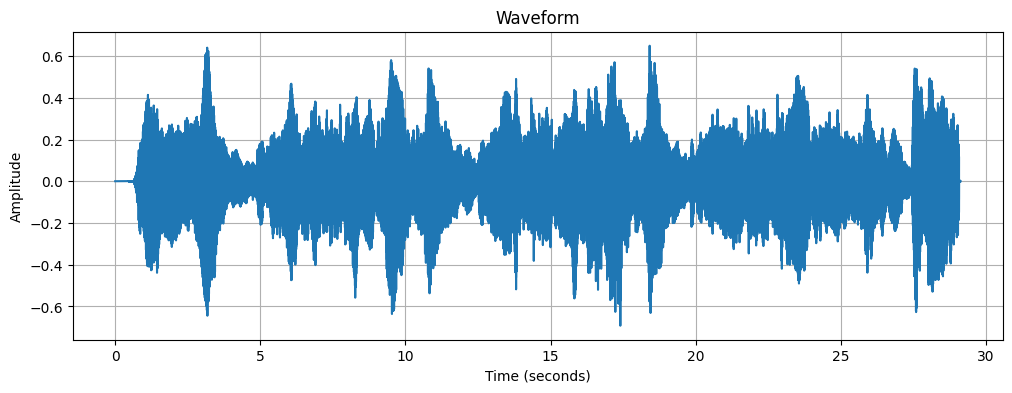

In [8]:
plot_waveform(signal, sampling_rate)

In [9]:
# Get number of channels
num_channels = AudioUtil.get_audio_channels(aud)
print(f'Number of channels: {num_channels}')

Number of channels: 1


In [10]:
# Get the duration of the audio file
duration = AudioUtil.get_audio_duration(aud)
print(f'Duration of audio: {duration}')

Duration of audio: 29.124


In [11]:
spec = torch.stft(signal, n_fft=2024, return_complex=True)
print(spec)


tensor([[[ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          -1.5948e-07+0.0000e+00j,  ...,
           2.6052e+00+0.0000e+00j,  2.1687e+00+0.0000e+00j,
           2.8488e-01+0.0000e+00j],
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          -1.6068e-07+3.3746e-09j,  ...,
          -6.1531e-01-4.8276e-02j,  1.1077e-01-1.2269e+00j,
          -1.1345e-01-6.3474e-01j],
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          -1.6407e-07+5.9333e-09j,  ...,
           5.3848e-01-3.9259e-01j,  9.9150e-02+1.2995e-01j,
          -6.9027e-01-5.9723e-01j],
         ...,
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          -1.6679e-09-1.1639e-11j,  ...,
           4.9880e-02-2.0714e-04j, -7.2018e-02+2.7977e-04j,
           5.8126e-02-1.5259e-04j],
         [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          -1.6682e-09-5.7199e-12j,  ...,
           4.9861e-02-5.1767e-05j, -7.1946e-02+1.2672e-04j,
           5.8094e-02-1.0490e-04j],
 

In [12]:
def plot_spectrogram(signal, sample_rate, window_size=2048, hop_length=512, title="Spectrogram"):
    # Perform the Short-Time Fourier Transform (STFT)
    signal = signal[0]
    
    spec = torch.stft(signal, n_fft=window_size, hop_length=hop_length, window=torch.hann_window(window_size), return_complex=True)
    
    spec_mag = torch.abs(spec)
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 6))
    plt.imshow(spec_mag.t().numpy(), origin='lower', aspect='auto', cmap='viridis', extent=[0, signal.shape[-1] / sample_rate, 0, sample_rate / 2])
    plt.colorbar(label='Magnitude')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

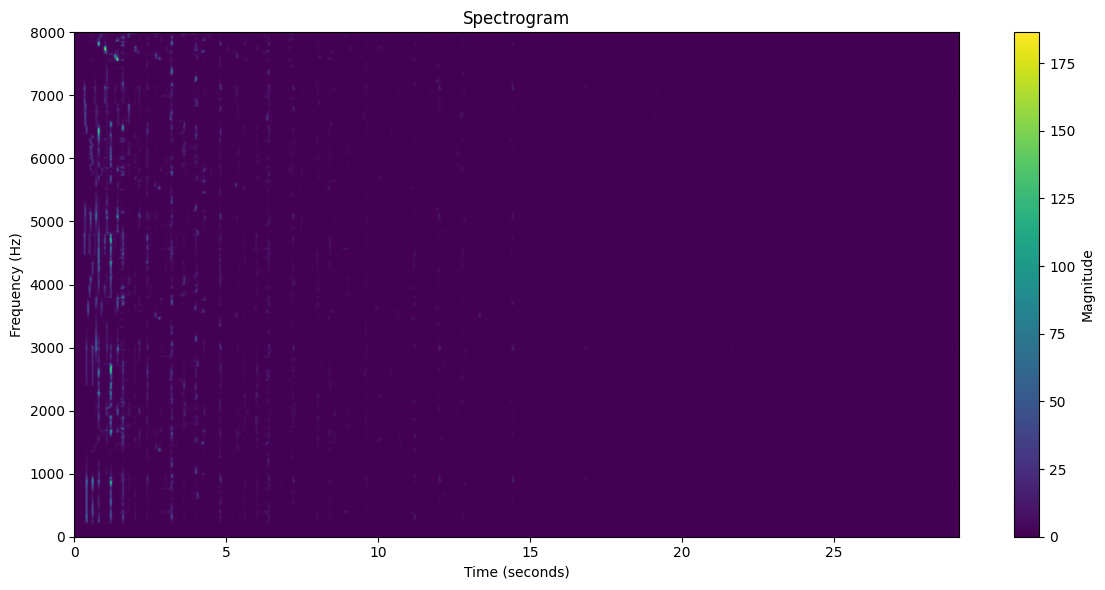

In [13]:
plot_spectrogram(signal, sampling_rate)

In [14]:
def plot_mel_spectrogram(aud, n_mels=64, n_fft=1024, hop_len=512, title="Mel Spectrogram"):
    signal, sample_rate = aud

    # Generate the Mel Spectrogram with dB
    mel_spec = AudioUtil.mel_spectrogram_with_db(aud, n_mels=n_mels, n_fft=n_fft, hop_len=hop_len)

    # Each frame or column in the spectrogram corresponds to hop_length / sample_rate seconds
    num_time_steps = mel_spec.shape[-1]
    time_axis = torch.arange(0, num_time_steps) * hop_len / sample_rate

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec[0].detach().numpy(), aspect='auto', origin='lower', cmap='inferno', 
               extent=[0, max(time_axis), 0, n_mels])
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mel-frequency')
    plt.tight_layout()
    plt.show()

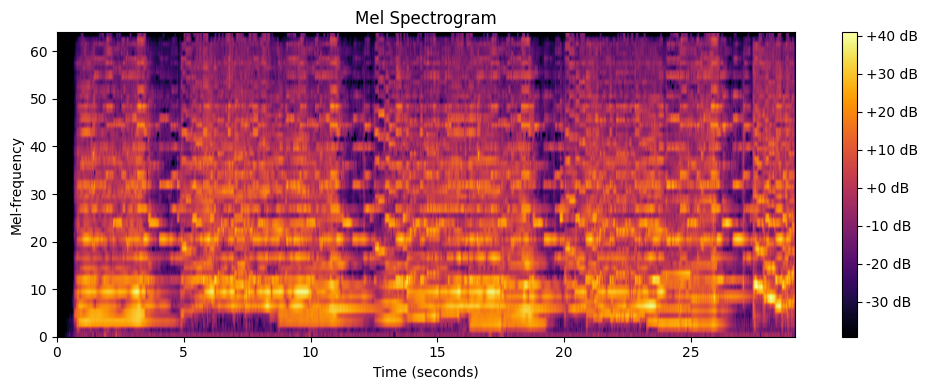

In [15]:
mel_sgram = AudioUtil.mel_spectrogram_with_db(aud)
plot_mel_spectrogram(aud)

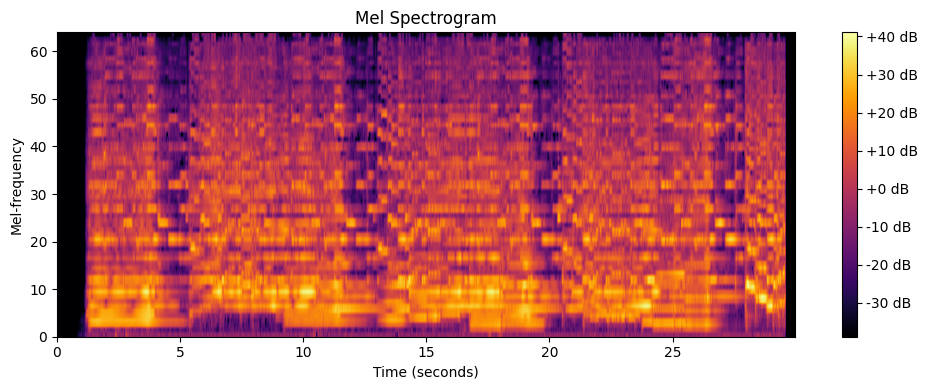

In [22]:
# Fixing time by padding / truncating
fixed_time_aud = AudioUtil.fix_audio_length(aud, max_s=30)
plot_mel_spectrogram(fixed_time_aud)

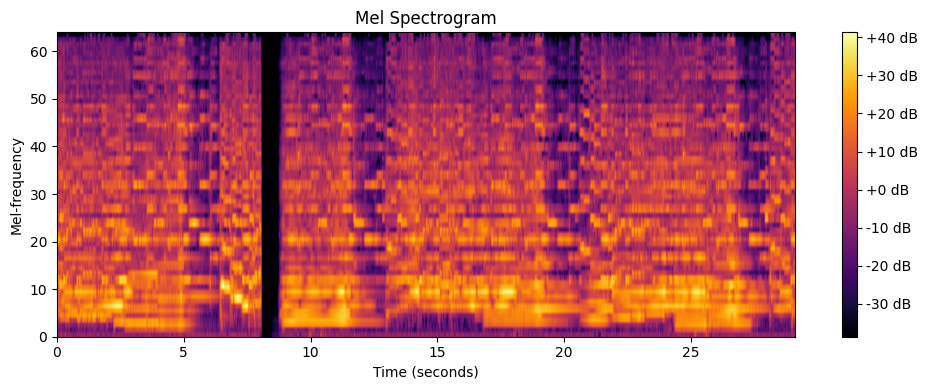

In [17]:
# Time stretching
shifted_aud = AudioUtil.time_shift(aud, shift_limit=0.4)
plot_mel_spectrogram(shifted_aud)

### Iterate over mtat data

In [42]:
data_path = '../data/'

In [43]:
mtat.head()

,singer,duet,plucking,world,bongos,harpsichord,sitar,chorus,female opera,clarinet,...,noise,choir,rap,hiphop,water,baroque,fiddle,english,filepath,data_origin
0,False,0,0,0,0,False,0,0,0,0,...,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1
1,False,0,0,0,0,False,0,0,0,0,...,0,False,0,0,0,1,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1
2,False,0,0,0,0,False,0,0,0,0,...,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1
3,False,0,0,0,0,False,0,0,0,0,...,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1
4,False,0,0,0,0,False,0,0,0,0,...,0,False,0,0,0,0,0,0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1


In [44]:
# Initialize an empty list to store the data
metadata = []
error_files = []  # List to store paths of problematic files

# Iterate over the filepaths in the subset DataFrame
for file in tqdm(mtat['filepath'], desc='Processing audio files'):
    try:
        # Construct the full file path for the audio file
        full_path = data_path + file
        # Use your AudioUtil class to open the audio file
        audio = AudioUtil.open(full_path)
        signal, sampling_rate = audio
        num_channels = AudioUtil.get_audio_channels(audio)
        audio_length = AudioUtil.get_audio_duration(audio)

        # Create a dictionary of the data you want to store
        audio_info = {
            'filepath': file,
            'audio_channels': num_channels, 
            'sampling_rate': sampling_rate,
            'audio_length': audio_length,
            #TODO more features
        }

        # Append the dictionary to your list
        metadata.append(audio_info)
        
    except Exception as e: 
        print(f"Failed to process {file}: {e}")
        error_files.append({'filepath': file, 'error': str(e)})

# Convert the list of dictionaries to a new DataFrame
metadata_df = pd.DataFrame(metadata)
error_df = pd.DataFrame(error_files)

Processing audio files:  63%|██████▎   | 16263/25863 [04:05<02:20, 68.17it/s]

Failed to process mtat/6/norine_braun-now_and_zen-08-gently-117-146.mp3: Failed to open the input "../data/mtat/6/norine_braun-now_and_zen-08-gently-117-146.mp3" (Invalid argument).


Processing audio files:  96%|█████████▌| 24879/25863 [06:13<00:14, 67.71it/s]

Failed to process mtat/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3: Failed to open the input "../data/mtat/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3" (Invalid argument).


Processing audio files:  99%|█████████▉| 25558/25863 [06:23<00:04, 61.89it/s]

Failed to process mtat/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3: Failed to open the input "../data/mtat/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3" (Invalid argument).


Processing audio files: 100%|██████████| 25863/25863 [06:28<00:00, 66.62it/s]


In [ ]:
# Print audio files where processing didn't work
error_df

In [ ]:
# delete those from the label data
error_file_set = set(error_df['filepath'])
label  = label[~label['filepath'].isin(error_file_set)]

In [45]:
# Check cols of metadata
metadata_df.head()

,filepath,audio_channels,sampling_rate,audio_length
0,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1,16000,29.124
1,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1,16000,29.124
2,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1,16000,29.124
3,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1,16000,29.124
4,mtat/f/american_bach_soloists-j_s__bach_solo_c...,1,16000,29.124


In [46]:
# Audio channels
metadata_df['audio_channels'].value_counts()

audio_channels
1    25860
Name: count, dtype: int64

In [47]:
# Sampling rate
metadata_df['sampling_rate'].value_counts()

sampling_rate
16000    25860
Name: count, dtype: int64

In [49]:
# Audio length
metadata_df.audio_length.value_counts()

audio_length
29.124    25860
Name: count, dtype: int64

### Iterate over Gtzan data